In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [163]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [164]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [165]:
from IPython.core.debugger import set_trace

def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    recs = np.random.choice(items_weights.item_id, 
                            size=n, 
                            replace=False, 
                            p=items_weights.weight)
    
    return recs.tolist()

In [166]:
import re

result = pd.read_csv('predictions_basic.csv', 
                     index_col=0, 
                     converters={
                         'actual': lambda x: list(map(int, x[1:-1].strip().split())),
                         'random_recommendation': lambda x: list(map(int, x[1:-1].strip().split(','))),
                         'popular_recommendation': lambda x: list(map(int, x[1:-1].strip().split(','))),
                         'itemitem': lambda x: list(map(int, x[1:-1].strip().split(','))),
                         'cosine': lambda x: list(map(int, x[1:-1].strip().split(','))),
                         'tfidf': lambda x: list(map(int, x[1:-1].strip().split(','))),
                         'own_purchases': lambda x: [] if x == '[]' else list(map(int, re.sub(r"\s+", "", x[1:-1], flags=re.UNICODE).split(','))),
                     })
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1019719, 2332987, 5550112, 9858801, 1072575]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[1082185, 1029743, 995785, 1004906, 1081177]","[16809367, 897125, 12188625, 854354, 9296853]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[839002, 13158305, 12354593, 8199063, 15597006]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[1082185, 1098066, 6534178, 1127831, 1068719]","[1024998, 1055950, 7166861, 13506119, 13094962]"


In [167]:
def get_item_weight(data_=data_train.copy()):
    # log 0 = inf
    data_['weight'] = data_.sales_value + 1

    item_weight = np.log(data_.groupby(by='item_id').agg({'weight':'sum'}))
    item_weight = item_weight / np.sum(item_weight)
    return item_weight.reset_index()

item_weight = get_item_weight()

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(item_weight))

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [168]:
def precision(recommended_list, bought_list):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(bought_list, recommended_list)
#     set_trace()
    return flags.sum() / len(recommended_list)

def precision_at_k(recommended_list, bought_list, k=5):
    return precision(recommended_list[:k], bought_list)

In [169]:
def get_score():
    for name_col in result.columns[2:]:
        print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")
get_score()

0.0008:random_recommendation
0.1552:popular_recommendation
0.1369:itemitem
0.1329:cosine
0.139:tfidf
0.2019:own_purchases
0.0014:weighted_random_recommendation


/var/folders/1_/j7l5d4m57nq4fn7lkcd7rqfw0000gn/T/ipykernel_64810/3767753485.py:6: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [170]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()


In [171]:
def top_at_n(data = data_train.copy(), n=5000):
    top_items = data.groupby(by='item_id').agg({'quantity': 'sum'}).sort_values(by='quantity', ascending=False)
    top_items = top_items.iloc[:n]
    top_items = top_items.rename(columns={'quantity':'top_5000'})
    data = data.merge(top_items, on=['item_id'], how='left')
    data.fillna(0)
    data['top_5000'] = np.where(data.top_5000 > 0, 1, 0)
    return data.loc[data['top_5000'] > 0].drop('top_5000', axis=1)

data_train_at_5000 = top_at_n()
data_train_at_5000.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [172]:
%%time

items = data_train_at_5000.item_id.unique()

result['random_recommendation_5000'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))


CPU times: user 203 ms, sys: 12.6 ms, total: 216 ms
Wall time: 215 ms


In [173]:
item_weight = get_item_weight(data_train_at_5000)

result['weighted_random_recommendation_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(item_weight))

In [174]:
get_score()

0.0008:random_recommendation
0.1552:popular_recommendation
0.1369:itemitem
0.1329:cosine
0.139:tfidf
0.2019:own_purchases


/var/folders/1_/j7l5d4m57nq4fn7lkcd7rqfw0000gn/T/ipykernel_64810/3767753485.py:6: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


0.0014:weighted_random_recommendation
0.0049:random_recommendation_5000
0.0075:weighted_random_recommendation_5000


In [184]:
def create_user_item_matrix(data,
                            item_column_name='item_id',
                            count_item_column_name='quantity',
                            user_column_name='user_id'
                           
                           ):
    popularity = data.groupby(item_column_name)[count_item_column_name].sum().reset_index()
    popularity.rename(columns={count_item_column_name: 'n_sold'}, inplace=True)
    top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000)[item_column_name].tolist()
    data_train.loc[~data['item_id'].isin(top_5000), 'item_id'] = 999999
    
    user_item_matrix = pd.pivot_table(data, 
                                  index=user_column_name, columns=item_column_name, 
                                  values=count_item_column_name,
                                  aggfunc='count', 
                                  fill_value=0
                                 )

    user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
    
    return user_item_matrix


def get_user_items_dicts(user_item_matrix):
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    return itemid_to_id, userid_to_id, id_to_itemid, id_to_userid



In [185]:
user_item_matrix = create_user_item_matrix(data_train)
itemid_to_id, userid_to_id, id_to_itemid, id_to_userid = get_user_items_dicts(user_item_matrix)

In [208]:
from tqdm import tqdm
import swifter


K = [2, 5, 8, 10]

score = []

for i, k in enumerate(K, start=1):
    
    
    model = ItemItemRecommender(K=k, num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),
             show_progress=False)
    print(f'loop {i} a {len(K)}')
#     tqdm.pandas()
    result['itemitem'] = result['user_id'].swifter.apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                        model.recommend(userid=userid_to_id[x], 
                                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=[999999], 
                                        recalculate_user=True,
                                    
                                        )])
    
    score.append(
        round(
            result.apply(
                lambda row: precision_at_k(row['itemitem'], row['actual']), 
                axis=1
            ).mean(),
            4)
    )


loop 1 a 4


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

loop 2 a 4


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

loop 3 a 4


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

loop 4 a 4


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [209]:
score

[0.192, 0.1369, 0.1472, 0.1509]

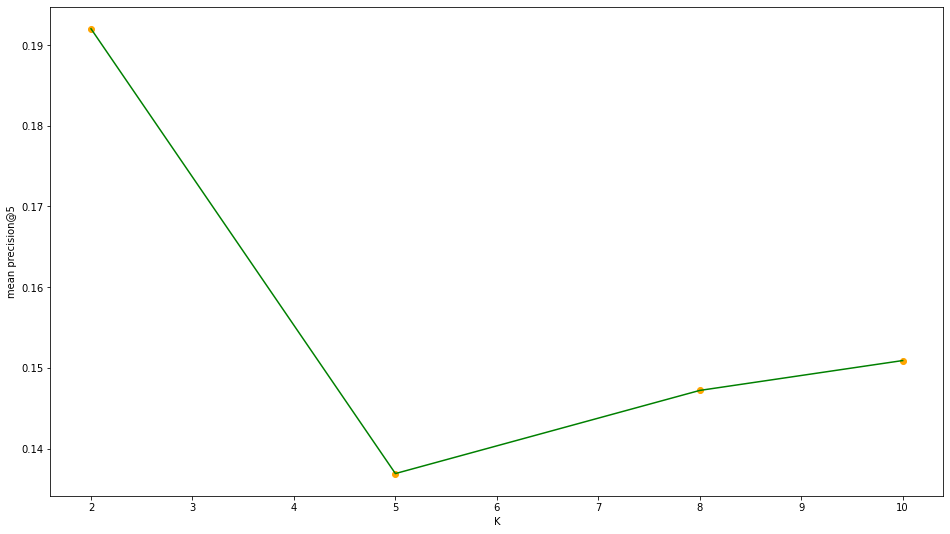

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(K, score, c='green')
plt.scatter(K, score, c='orange')
plt.xlabel('K')
plt.ylabel('mean precision@5')
plt.show()

In [216]:
model = ItemItemRecommender(K=2, num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),
         show_progress=True)

result['itemitem'] = result['user_id'].swifter.apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                    model.recommend(userid=userid_to_id[x], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[999999], 
                                    recalculate_user=True,

                                    )])

  0%|          | 0/5000 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [217]:
get_score()

0.0008:random_recommendation
0.1552:popular_recommendation
0.192:itemitem
0.1329:cosine
0.139:tfidf
0.2019:own_purchases


/var/folders/1_/j7l5d4m57nq4fn7lkcd7rqfw0000gn/T/ipykernel_64810/3767753485.py:6: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)


0.0014:weighted_random_recommendation
0.0049:random_recommendation_5000
0.0075:weighted_random_recommendation_5000


Значениие k=2 по сымслу похоже на own purchases

In [219]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation,random_recommendation_5000,weighted_random_recommendation_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1019719, 2332987, 5550112, 9858801, 1072575]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 995242, 1029743, 840361]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[1082185, 1029743, 995785, 1004906, 1081177]","[1032115, 1051197, 6034277, 1644730, 914322]","[1137483, 1043128, 1113768, 1121624, 829459]","[9705473, 903350, 822241, 825176, 928342]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[839002, 13158305, 12354593, 8199063, 15597006]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 1098066, 6534178, 826249]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[1082185, 1098066, 6534178, 1127831, 1068719]","[1846901, 249890, 75888, 1022433, 44657]","[1067695, 931532, 6395907, 997821, 6039859]","[974156, 948953, 985181, 997988, 854042]"
